# Part 1
Based on the provided csv of transaction data, an LTV Heatmap is to be created. 


## Setup for analysis
The following SQL queries were done on transaction_data.csv to derive the cohort and period that each transaction fell under:

The cohorts of each account_id was derived from the SQL query: 

> CREATE TABLE customer_cohorts AS
SELECT account_id,
MIN(payment_date) AS first_payment,
DATE_FORMAT(MIN(payment_date),'%Y-%m') AS cohort
FROM transaction_data
GROUP BY account_id;

Each transaction was matched with its corresponding cohort and period with the SQL query: 
> CREATE TABLE transaction_periods AS
SELECT td.payment_id, td.account_id, cc.cohort, td.payment_usd,
TIMESTAMPDIFF(MONTH, cc.first_payment, td.payment_date) AS period
FROM transaction_data AS td
INNER JOIN customer_cohorts AS cc
ON cc.account_id = td.account_id;

All SQL queries and other relevant files can be viewed [here](https://github.com/xingweird/productanalyst).

In [92]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# read file
url = 'https://raw.githubusercontent.com/xingweird/productanalyst/main/transactions.csv'
df1 = pd.read_csv(url)



## Deriving LTV
Pivoting the original table and performing cumulative summing operations on the transaction data, we have the LTV for each cohort by periods. 

> **Lifetime value (LTV)** is the the cumulative revenue realized per customer.

> **Cohorts** segment a company’s customers into groups based on the year and month they became customers. 

> **Period** is the number of months that has passed since the first payment date. 

LTV for a given cohort at age T is computed as the total revenue realized by that cohort up to T divided by the total number of customers in the cohort including customers who may have churned out. 

(Source: [Tribe Capital 1](https://medium.com/swlh/diligence-at-social-capital-part-3-cohorts-and-revenue-ltv-ab65a07464e1))


(Source: [Tribe Capital 2](https://tribecap.co/a-quantitative-approach-to-product-market-fit/))






In [93]:
# read file
url = 'https://raw.githubusercontent.com/xingweird/productanalyst/main/cohorts.csv'
df1_accounts = pd.read_csv(url)

In [94]:
# cohort counts - uninedexed for ease of barplotting later 
df1_cohorts = df1_accounts.copy()
df1_cohorts = df1_cohorts.groupby(['cohort'], as_index = False).count()
df1_cohorts = df1_cohorts[['cohort', 'account_id']]
df1_cohorts.columns = ['cohort', 'cohort_size']

# cohort counts - cohort as index for ltv calculation
df1_cohorts2 = df1_accounts.copy()
df1_cohorts2 = df1_cohorts2.groupby(['cohort']).count()
df1_cohorts2 = df1_cohorts2[['account_id']]
df1_cohorts2.columns = ['cohort_size']
df1_cohorts2

,cohort_size
cohort,
2020-02,85
2020-03,276
2020-04,34
2020-05,40
2020-06,52
2020-07,69
2020-08,109
2020-09,133
2020-10,99


In [95]:
# ltv
df1_ltv = df1.copy()

def divide(row):
    for i, sum in enumerate(row):
        # updating the value of the row
        row[i] = (sum/df1_cohorts2.loc[row.name])/1000
    return row

# get desired table for heatmap
df1_ltv = df1_ltv.groupby(['cohort', 'period']).apply(lambda x: x['payment_usd'].sum())
df1_ltv = df1_ltv.unstack(level= 1)
df1_ltv = df1_ltv.cumsum(axis = 1)
df1_ltv = df1_ltv.apply(divide, axis = 1)
df1_ltv

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2020-02,0.705269,1.368666,2.047903,2.769095,3.522070,4.324317,5.171117,6.265927,7.221615,8.815564,9.997890,10.377998
2020-03,0.535333,1.009492,1.504653,2.032967,2.604422,3.200026,3.818362,4.508485,5.632685,6.492685,7.010207,NaN
2020-04,0.314656,0.720758,1.035848,1.406509,1.800296,2.192410,2.642484,3.101671,3.525825,3.797407,NaN,NaN
2020-05,0.350193,0.655641,1.032953,1.403956,1.772383,2.261329,2.859758,3.358721,3.643949,NaN,NaN,NaN
2020-06,0.247513,0.638257,1.049161,1.478036,2.104140,2.649014,3.594437,4.124244,NaN,NaN,NaN,NaN
2020-07,0.360550,0.834417,1.351746,1.923809,2.669253,3.260479,3.404919,NaN,NaN,NaN,NaN,NaN
2020-08,0.316529,0.666236,1.054907,1.478556,2.057821,2.368464,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,0.227885,0.486410,0.799904,1.144121,1.389786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10,0.334471,0.849356,1.557395,1.877668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting the Heatmap
To also showcase the cohort size, a horizontal barplot is included along the heatmap's y-axis.

> The cohort size is included because it is common to see situations where cohort sizes are increasing while simultaneously shrinking LTVs. Acquiring a lot more customers isn’t necessarily great if you’re making so much less money on them that you end up in the same place or worse. ([Tribe Capital](https://tribecap.co/a-quantitative-approach-to-product-market-fit/))

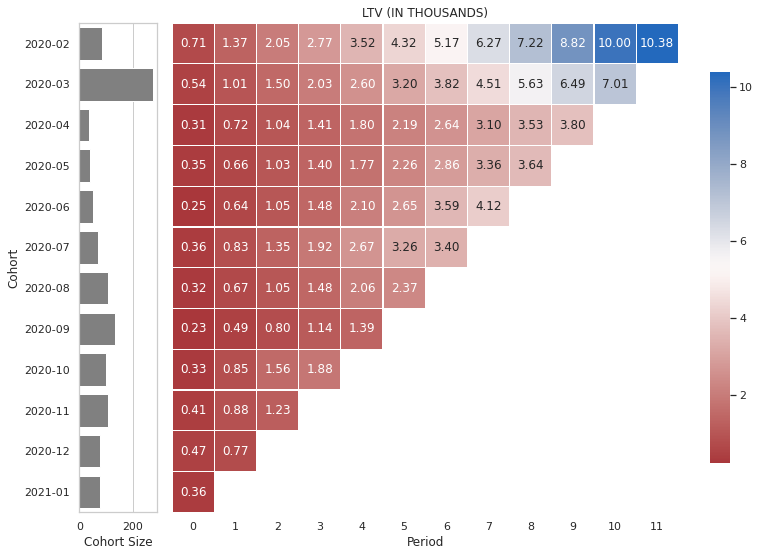

In [96]:
grid = plt.GridSpec(1, 8, wspace=0.2, hspace=0.3)
plt.subplots(figsize=(13, 9))

#plot barplot
plt.subplot(grid[0, 0])
sb.barplot(y = "cohort", x = "cohort_size", data = df1_cohorts, color = 'grey')
plt.xlabel('Cohort Size')
plt.ylabel('Cohort')

# plot heatmap
plt.subplot(grid[0, 1:])
sb.heatmap(df1_ltv, cmap="vlag_r", annot=True, fmt=".2f",
           linewidth=0.2, cbar_kws={"shrink": .8}, yticklabels=False)

# xticks
xticks_labels = ['0', '1', '2', '3', '4', '5',
                '6', '7', '8', '9', '10', '11']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('Period')
plt.ylabel('')

# title
title = 'LTV (in thousands)'.upper()
plt.title(title, loc='center')

plt.show()

## Observations
1. **Age effects (vertical):**
* Decreasing vertically from 2020-04 to 2020-09, while cohort size increases. 

> It is common to see situations where cohort sizes are increasing while simultaneously shrinking LTVs. Acquiring a lot more customers isn’t necessarily great if you’re making so much less money on them that you end up in the same place or worse. ([Tribe Capital](https://tribecap.co/a-quantitative-approach-to-product-market-fit/))

* Rebounding vertically from 2020-10 to 2021-01, while cohort size decreases, suggesting increased pricing, though perhaps limited data to draw any significant finding. 

2. **Single cohort effects (horizontal):**
* 2020-02 and 2020-03 LTV stand out as an outliers in how quickly they turn blue.
* 2020-03 however, has a unusually large cohort size in comparison to other cohorts. Coupled with the horizontal effect observed, the company might have had a big marketing spend that month that resulted in mass acquisition. 
* 2020-02 has a comparable cohort size to other subsequent cohorts but boasts high LTV, suggesting that the cohort contains big clients. 

3. **Fixed calendar time effects (diagonally):**
None observed. 

4. **Other**
* In 2020-04 and 2020-05, the cohort size is the smallest but it has a comparable first period LTV to previous cohorts. The cohort likely includes more medium to large clients. 
* Sublinear LTV.





# Part 2
LTV Heatmap is broken down for “small”, “medium”, and “large” clients.

LTV differs between these segments and a recommendation on which segment is “healthiest” is to be provided.

## Setup for analysis
The average monthly transactions for each client is derived. 

Clients are to be later broken down into small, medium and large based on their average monthly transactions: 
> **Small**: < 1k 
**Medium**: 1k-4k 
**Large**: > 4k 

Based on the right-skewed distribution of the average monthly transactions, it can be deduced that majority of clients are small.

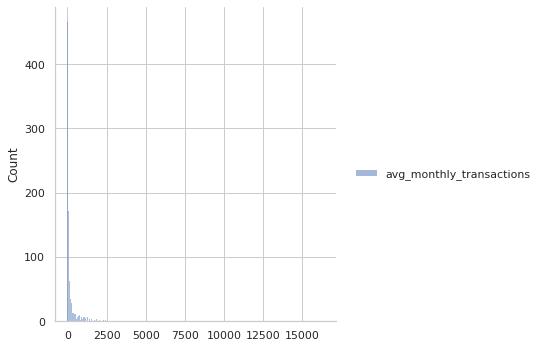

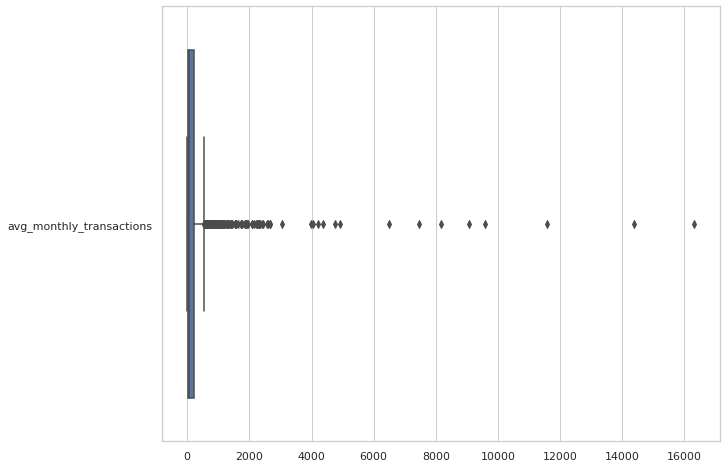

In [107]:
#Derive the average monthly transactions for clients
df1_clients = df1.copy()
df1_clients = df1_clients.groupby(['account_id'], as_index = False).apply(lambda x: x['payment_usd'].sum()/12) 
df1_clients.columns = ['account_id', 'avg_monthly_transactions']

#Distribution exploratory analysis
sb.displot(df1_clients)

sb.set(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sb.boxplot(data= df1_clients, orient="h")

plt.show()

##Small Clients
As per part 1, the LTV heatmap is produced for only small clients.

### Deriving LTV

In [108]:
#Small: <1k  
df1_smallclients = df1_clients.copy()
df1_smallclients = df1_smallclients[df1_smallclients['avg_monthly_transactions'] < 1000]

# filter for only small clients (cohort counts)
df1_smallclients_cohorts = df1_accounts.copy()
df1_smallclients_cohorts = df1_smallclients_cohorts[df1_smallclients_cohorts['account_id'].isin(df1_smallclients['account_id'])]
df1_smallclients_cohorts2 = df1_smallclients_cohorts.copy()

# cohort counts - uninedexed for ease of barplotting later 
df1_smallclients_cohorts = df1_smallclients_cohorts.groupby(['cohort'], as_index = False).count()
df1_smallclients_cohorts = df1_smallclients_cohorts[['cohort', 'account_id']]
df1_smallclients_cohorts.columns = ['cohort', 'cohort_size']

# cohort counts - cohort as index for ltv calculation
df1_smallclients_cohorts2 = df1_smallclients_cohorts2.groupby(['cohort']).count()
df1_smallclients_cohorts2 = df1_smallclients_cohorts2[['account_id']]
df1_smallclients_cohorts2.columns = ['cohort_size']
df1_smallclients_cohorts2


,cohort_size
cohort,
2020-02,65
2020-03,240
2020-04,30
2020-05,38
2020-06,47
2020-07,64
2020-08,102
2020-09,129
2020-10,95


In [109]:
# ltv

# filter for only small clients (LTV)
df1_smallclients_ltv = df1.copy()
df1_smallclients_ltv = df1_smallclients_ltv[df1_smallclients_ltv['account_id'].isin(df1_smallclients['account_id'])]

def divide(row):
    for i, sum in enumerate(row):
        # updating the value of the row
        row[i] = (sum/df1_smallclients_cohorts2.loc[row.name])/1000
    return row

# get desired table for heatmap
df1_smallclients_ltv = df1_smallclients_ltv.groupby(['cohort', 'period']).apply(lambda x: x['payment_usd'].sum())
df1_smallclients_ltv = df1_smallclients_ltv.unstack(level= 1)
df1_smallclients_ltv = df1_smallclients_ltv.cumsum(axis = 1)
df1_smallclients_ltv = df1_smallclients_ltv.apply(divide, axis = 1)
df1_smallclients_ltv

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2020-02,0.288081,0.572926,0.819456,1.031419,1.255469,1.468797,1.674609,1.879672,2.071816,2.254573,2.413435,2.5099
2020-03,0.321164,0.548230,0.780779,0.998510,1.213172,1.424021,1.627198,1.826987,2.025396,2.252355,2.412051,NaN
2020-04,0.220979,0.494172,0.654784,0.890018,1.125382,1.315656,1.499912,1.664472,1.829540,2.001161,NaN,NaN
2020-05,0.223888,0.328427,0.449182,0.552503,0.655916,0.876013,1.115776,1.316580,1.441420,NaN,NaN,NaN
2020-06,0.213404,0.474634,0.717339,0.979660,1.236071,1.526746,1.847846,2.065681,NaN,NaN,NaN,NaN
2020-07,0.253644,0.616205,0.951205,1.320517,1.811570,2.175265,2.312969,NaN,NaN,NaN,NaN,NaN
2020-08,0.216210,0.427623,0.642261,0.897741,1.170890,1.335206,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,0.199440,0.369869,0.549730,0.778373,0.949176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10,0.322502,0.614348,0.984729,1.161428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting the Heatmap

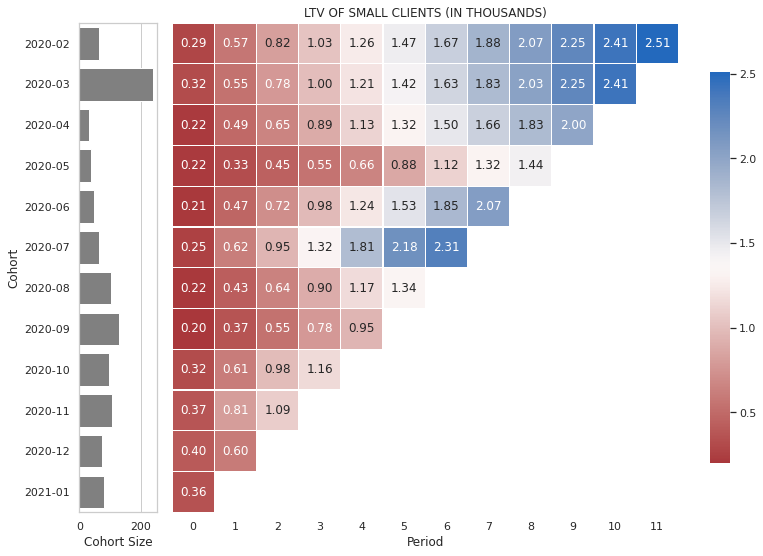

In [110]:
grid = plt.GridSpec(1, 8, wspace=0.2, hspace=0.3)
plt.subplots(figsize=(13, 9))

#plot barplot
plt.subplot(grid[0, 0])
sb.barplot(y = "cohort", x = "cohort_size", data = df1_smallclients_cohorts, color = 'grey')
plt.xlabel('Cohort Size')
plt.ylabel('Cohort')

# plot heatmap
plt.subplot(grid[0, 1:])
sb.heatmap(df1_smallclients_ltv, cmap="vlag_r", annot=True, fmt=".2f",
           linewidth=0.2, cbar_kws={"shrink": .8}, yticklabels=False)

# xticks
xticks_labels = ['0', '1', '2', '3', '4', '5',
                '6', '7', '8', '9', '10', '11']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('Period')
plt.ylabel('')

# title
title = 'LTV of small clients (in thousands)'.upper()
plt.title(title, loc='center')

plt.show()

### Observations
1. **Age effects (vertical):**
* No discernable meaningful pattern vertically. In comparison to health of joint LTV, more instances of generally increasing vertically as cohorts become more recent. This points towards considerable LTV health of small clients in comparison to health of joint LTV as newer cohorts are spending more and increasing spending faster. 

* Generally decreasing LTV from 2020-04 to 2020-09, while cohort size increases but 2020-06 and 2020-07 are outliers. 

> It is common to see situations where cohort sizes are increasing while simultaneously shrinking LTVs. Acquiring a lot more customers isn’t necessarily great if you’re making so much less money on them that you end up in the same place or worse. ([Tribe Capital](https://tribecap.co/a-quantitative-approach-to-product-market-fit/))

* Rebounding LTV from 2020-10 to 2021-01, while cohort size decreases, though perhaps limited data to draw any significant finding. 

2. **Single cohort effects (horizontal):**
* 2020-05 stand out as an outlier in how slowly it turns blue.
* 2020-07 stands out as an outlier in how quickly it turns blue. 

3. **Fixed calendar time effects (diagonally):**
From 2020-02 to 2020-07 there is a diagonal pattern observed, suggesting a seasonal occurence such as a sale that increased spending per customer. 

4. **Other**
* The unusually large cohort size of 2020-03 does not affect its LTV, suggesting the presence of medium/large clients that skew the high LTV seen in the joint client heatmap.   
* Cohort size distribution follows that of all clients. This is expected given the finding that majority of clients are made up of small clients.  
* Sublinear LTV. 


##Medium Clients
As per part 1, the LTV heatmap is produced for only medium clients.

### Deriving LTV

In [111]:
#Medium: 1k-4k 
df1_mediumclients = df1_clients.copy()
df1_mediumclients = df1_mediumclients[(df1_mediumclients['avg_monthly_transactions'] >= 1000) & (df1_mediumclients['avg_monthly_transactions'] <= 4000)]

# filter for only medium clients (cohort counts)
df1_mediumclients_cohorts = df1_accounts.copy()
df1_mediumclients_cohorts = df1_mediumclients_cohorts[df1_mediumclients_cohorts['account_id'].isin(df1_mediumclients['account_id'])]
df1_mediumclients_cohorts2 = df1_mediumclients_cohorts.copy()

# cohort counts - uninedexed for ease of barplotting later 
df1_mediumclients_cohorts = df1_mediumclients_cohorts.groupby(['cohort'], as_index = False).count()
df1_mediumclients_cohorts = df1_mediumclients_cohorts[['cohort', 'account_id']]
df1_mediumclients_cohorts.columns = ['cohort', 'cohort_size']

# cohort counts - cohort as index for ltv calculation
df1_mediumclients_cohorts2 = df1_mediumclients_cohorts2.groupby(['cohort']).count()
df1_mediumclients_cohorts2 = df1_mediumclients_cohorts2[['account_id']]
df1_mediumclients_cohorts2.columns = ['cohort_size']
df1_mediumclients_cohorts2

,cohort_size
cohort,
2020-02,15
2020-03,29
2020-04,4
2020-05,1
2020-06,5
2020-07,5
2020-08,7
2020-09,4
2020-10,4


In [112]:
# ltv

# filter for only medium clients (LTV)
df1_mediumclients_ltv = df1.copy()
df1_mediumclients_ltv = df1_mediumclients_ltv[df1_mediumclients_ltv['account_id'].isin(df1_mediumclients['account_id'])]

def divide(row):
    for i, sum in enumerate(row):
        # updating the value of the row
        row[i] = (sum/df1_mediumclients_cohorts2.loc[row.name])/1000
    return row

# get desired table for heatmap
df1_mediumclients_ltv = df1_mediumclients_ltv.groupby(['cohort', 'period']).apply(lambda x: x['payment_usd'].sum())
df1_mediumclients_ltv = df1_mediumclients_ltv.unstack(level= 1)
df1_mediumclients_ltv = df1_mediumclients_ltv.cumsum(axis = 1)
df1_mediumclients_ltv = df1_mediumclients_ltv.apply(divide, axis = 1)
df1_mediumclients_ltv


period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2020-02,1.491195,2.988971,4.532173,6.132370,7.770986,9.312174,10.771011,12.552046,14.242940,16.707603,18.835893,19.664435
2020-03,1.304194,2.827384,4.450287,6.214419,8.036800,9.894617,11.755463,13.683341,15.783619,18.416401,20.493061,NaN
2020-04,1.017230,2.420148,3.893830,5.280188,6.862145,8.768065,11.211773,13.880660,16.247962,17.269257,NaN,NaN
2020-05,0.500000,1.375000,2.250000,3.125000,4.000000,4.875000,8.937190,12.937190,NaN,NaN,NaN,NaN
2020-06,0.568132,2.176314,4.168296,6.162774,10.263984,13.198338,20.012392,23.474736,NaN,NaN,NaN,NaN
2020-07,1.728946,3.627532,6.478670,9.645948,13.647604,17.151218,17.381872,NaN,NaN,NaN,NaN,NaN
2020-08,1.778321,4.143169,7.067747,9.941857,14.981683,17.424511,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,1.145230,4.244862,8.868002,12.939497,15.599442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10,0.618750,6.430792,15.158217,18.888377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plotting the Heatmap

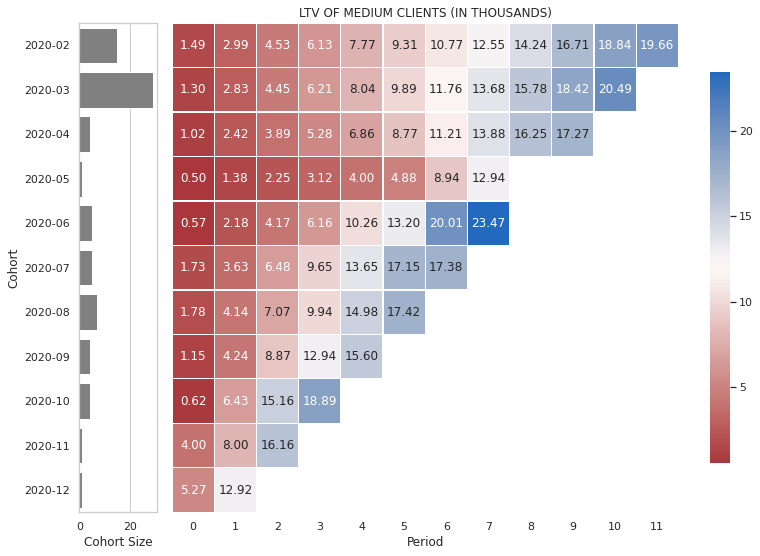

In [113]:
grid = plt.GridSpec(1, 8, wspace=0.2, hspace=0.3)
plt.subplots(figsize=(13, 9))

#plot barplot
plt.subplot(grid[0, 0])
sb.barplot(y = "cohort", x = "cohort_size", data = df1_mediumclients_cohorts, color = 'grey')
plt.xlabel('Cohort Size')
plt.ylabel('Cohort')

# plot heatmap
plt.subplot(grid[0, 1:])
sb.heatmap(df1_mediumclients_ltv, cmap="vlag_r", annot=True, fmt=".2f",
           linewidth=0.2, cbar_kws={"shrink": .8}, yticklabels=False)

# xticks
xticks_labels = ['0', '1', '2', '3', '4', '5',
                '6', '7', '8', '9', '10', '11']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('Period')
plt.ylabel('')

# title
title = 'LTV of medium clients (in thousands)'.upper()
plt.title(title, loc='center')

plt.show()

### Observations
1. **Age effects (vertical):**
* Increasing vertically from 2020-06 to 2020-08, while cohort size increases. 
* Increasing vertically from 2020-08 to 2020-12, while cohort size decreases. This means each customer in newer cohorts are spending more / price has increased which explains decreasing cohort size. 

2. **Single cohort effects (horizontal):**
* 2020-05 of cohort size 1 has a lower LTV and eventually churns in period 8.  

3. **Fixed calendar time effects (diagonally):**
Blue diagonal streak. 

4. **Other**
* Cohort size distribution is almost identical to that of all clients with the exception of 2020-05 which rather than increase from 2020-04, decreases and is very small. From 2020-05 onwards it is consistent, increasing to 2020-09, decreasing from 2020-10 to 2021-01; 2020-03 remains significantly larger than the rest of the cohorts. 
* We also observe that 2020-02 is an outlier- it is comparatively larger in cohort size than the other cohorts. 
* No medium clients in 2021-01.
* Almost linear to superlinear LTV growth in newer cohorts (2020-10 to 2020-12). 
* Increasing LTV both for later larger cohorts and later in the customer lifecycle: Increasing LTV from 2020-05 to 2020-08 as cohort sizes increase. 




##Large Clients
As per part 1, the LTV heatmap is produced for only large clients.

###Deriving LTV

In [114]:
#Large: >4k
df1_largeclients = df1_clients.copy()
df1_largeclients = df1_largeclients[df1_largeclients['avg_monthly_transactions'] > 4000]

# filter for only large clients (cohort counts)
df1_largeclients_cohorts = df1_accounts.copy()
df1_largeclients_cohorts = df1_largeclients_cohorts[df1_largeclients_cohorts['account_id'].isin(df1_largeclients['account_id'])]
df1_largeclients_cohorts2 = df1_largeclients_cohorts.copy()

# cohort counts - uninedexed for ease of barplotting later 
df1_largeclients_cohorts = df1_largeclients_cohorts.groupby(['cohort'], as_index = False).count()
df1_largeclients_cohorts = df1_largeclients_cohorts[['cohort', 'account_id']]
df1_largeclients_cohorts.columns = ['cohort', 'cohort_size']

# cohort counts - cohort as index for ltv calculation
df1_largeclients_cohorts2 = df1_largeclients_cohorts2.groupby(['cohort']).count()
df1_largeclients_cohorts2 = df1_largeclients_cohorts2[['account_id']]
df1_largeclients_cohorts2.columns = ['cohort_size']
df1_largeclients_cohorts2

,cohort_size
cohort,
2020-02,5
2020-03,7
2020-05,1


In [115]:
# ltv

# filter for only large clients (LTV)
df1_largeclients_ltv = df1.copy()
df1_largeclients_ltv = df1_largeclients_ltv[df1_largeclients_ltv['account_id'].isin(df1_largeclients['account_id'])]

def divide(row):
    for i, sum in enumerate(row):
        # updating the value of the row
        row[i] = (sum/df1_largeclients_cohorts2.loc[row.name])/1000
    return row

# get desired table for heatmap
df1_largeclients_ltv = df1_largeclients_ltv.groupby(['cohort', 'period']).apply(lambda x: x['payment_usd'].sum())
df1_largeclients_ltv = df1_largeclients_ltv.unstack(level= 1)
df1_largeclients_ltv = df1_largeclients_ltv.cumsum(axis = 1)
df1_largeclients_ltv = df1_largeclients_ltv.apply(divide, axis = 1)
df1_largeclients_ltv

period,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2020-02,3.770940,6.852378,10.564898,15.269058,20.241126,26.48250,33.826038,44.428894,53.105036,70.432328,82.081794,84.803954
2020-03,4.693013,9.292936,14.119837,20.176914,27.798853,36.35689,46.061736,58.435453,87.257270,102.477167,108.803723,NaN
2020-05,5.000000,12.370420,21.999180,32.038130,41.970510,52.28967,63.053640,71.381620,78.046820,NaN,NaN,NaN


### Plotting the Heatmap

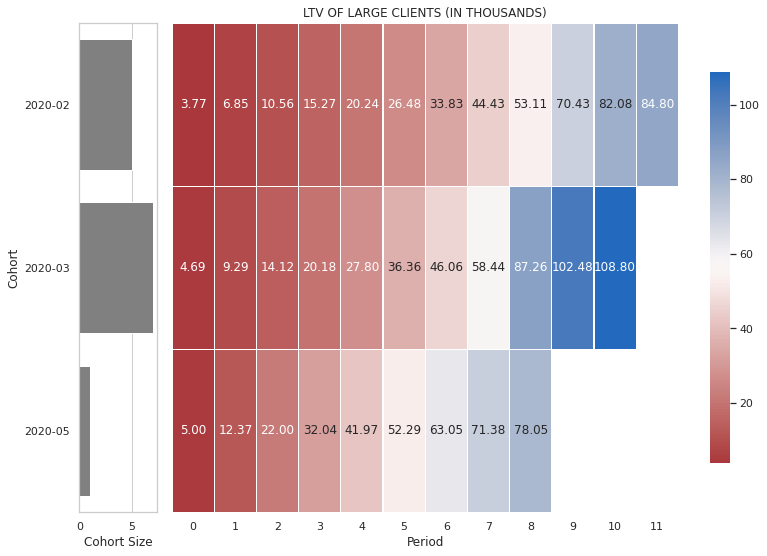

In [116]:
grid = plt.GridSpec(1, 8, wspace=0.2, hspace=0.3)
plt.subplots(figsize=(13, 9))

#plot barplot
plt.subplot(grid[0, 0])
sb.barplot(y = "cohort", x = "cohort_size", data = df1_largeclients_cohorts, color = 'grey')
plt.xlabel('Cohort Size')
plt.ylabel('Cohort')

# plot heatmap
plt.subplot(grid[0, 1:])
sb.heatmap(df1_largeclients_ltv, cmap="vlag_r", annot=True, fmt=".2f",
           linewidth=0.2, cbar_kws={"shrink": .8}, yticklabels=False)

# xticks
xticks_labels = ['0', '1', '2', '3', '4', '5',
                '6', '7', '8', '9', '10', '11']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('Period')
plt.ylabel('')

# title
title = 'LTV of large clients (in thousands)'.upper()
plt.title(title, loc='center')

plt.show()

### Observations
1. **Age effects (vertical):**
* Increasing vertically from 2020-02 to 2020-05.

2. **Single cohort effects (horizontal):**
None observed. 

3. **Fixed calendar time effects (diagonally):**
Blue streak diagonally.  

4. **Other**
* Sublinear LTV.
* There are only 3 cohorts that have large clients. 
* Having large clients in 2020-05 explains its increase in LTV from 2020-04 despite having comparable LTVs when filtering for small clients and a lower LTV when filtering for medium clients. 
* 2020-03 having more large clients is consistent with it having more clients in general. 
* 2020-02 having large clients (and comparatively more medium clients) explains why in the all clients view its LTV is growing faster. 

## Final Recommendation

A recommendation on which segment is **“healthiest”**:
> We want to see increasing LTV both for later larger cohorts and later in the customer lifecycle. 

> As the business attracts larger cohorts of customers it’s often the case that LTV degrades because the larger cohorts are made up of later adopting customers who are less inclined to use the product. If the product has truly great product-market fit then the later larger cohorts will monetize at even higher rates both as the cohorts get larger and as the cohorts age.

**Medium clients** exhibits this most. 

> Needless to say, what we really want to see are businesses that exhibit some strong evidence of linear to super-linear LTV in at least some of the cohorts of customer.

**Medium clients** exhibits this most. 

(Source: [Tribe Capital](https://medium.com/swlh/diligence-at-social-capital-part-3-cohorts-and-revenue-ltv-ab65a07464e1)) 

